In [2]:
#  pip install pandas numpy scikit-learn
#  pip install nltk
#  pip install tqdm
#  pip install gensim
#  pip install matplotlib

# Setup: Load Raw Dataset

In [3]:
import pandas as pd
import numpy as np
import re
#  from google.colab import drive

#  # Mount Google Drive
#  drive.mount('/content/drive')

#  --- File path ---
base_path = '../dataset/'
paper_path = base_path + 'papers.csv'
author_path = base_path + 'authors.csv'
paper_authors_path = base_path + 'paper_authors.csv'

#  --- Read CSV ---
try:
    df_paper = pd.read_csv(paper_path)
    df_author = pd.read_csv(author_path)
    df_paper_author = pd.read_csv(paper_authors_path)
    print("All CSV files loaded successfully!")
except FileNotFoundError as e:
    print("File loading failed: {e}")
    print("Please make sure your file paths are correct.")

All CSV files loaded successfully!


# Text Pre-processing

df_final shape before merge: {df_final.shape}
'authors_list' number of missing values in: {df_final['authors_list'].isnull().sum()}
df_final shape after cleaning: {df_final.shape}

Cleaned DataFrame (first 5 rows):
   year                                              title          abstract  \
0  1987  Self-Organization of Associative Database and ...  Abstract Missing   
1  1987  A Mean Field Theory of Layer IV of Visual Cort...  Abstract Missing   
2  1988  Storing Covariance by the Associative Long-Ter...  Abstract Missing   
3  1994  Bayesian Query Construction for Neural Network...  Abstract Missing   
4  1994  Neural Network Ensembles, Cross Validation, an...  Abstract Missing   

                                          paper_text  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   
1  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...   
2  394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...   
3  Bayesian Query Construction for Neural\nNetwor...   
4  Neural Network Ensemb

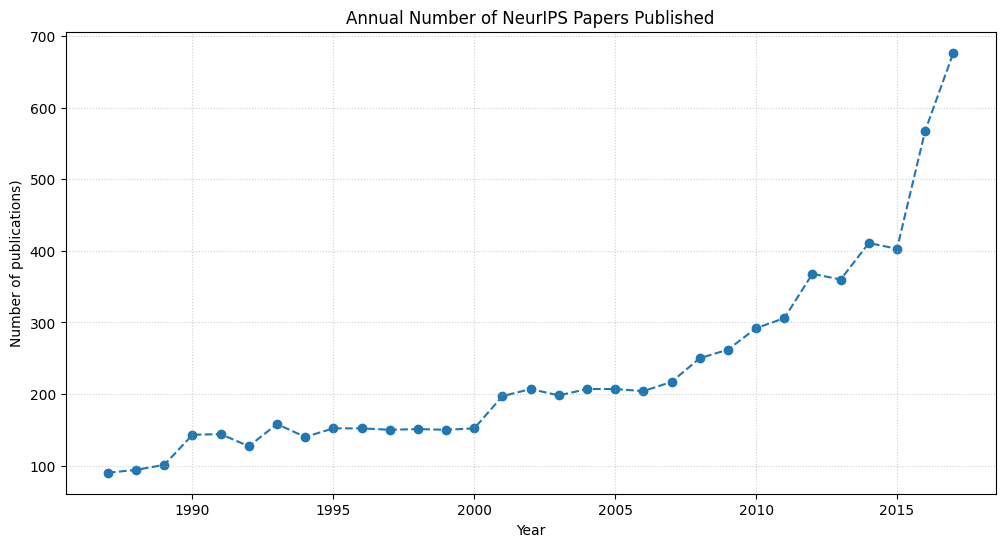

In [4]:
#  --- 1. Linking paper IDs and author names ---
#  使用 'paper_authors.csv' 作为桥梁，连接 'papers.csv' 和 'authors.csv'
df_merged_authors = pd.merge(
    df_paper_author,
    df_author[['id', 'name']],
    left_on='author_id',
    right_on='id',
    how='left'
)

#  --- 2. Group author names by paper_id ---
#  Compile all authors of the same paper into a single list
df_aggregated_authors = (
    df_merged_authors
    .groupby('paper_id')['name']
    .apply(list)
    .reset_index()
)
df_aggregated_authors.rename(columns={'name': 'authors_list'}, inplace=True)

#  --- 3. Connect to the master table ---
df_final = pd.merge(
    df_paper,
    df_aggregated_authors,
    left_on='id',
    right_on='paper_id',
    how='left'
)

#  --- 4. Data cleansing ---
print("df_final shape before merge: {df_final.shape}")

#  Check for missing values in 'authors_list'
print("'authors_list' number of missing values in: {df_final['authors_list'].isnull().sum()}")

#  移除没有作者信息的行
df_final.dropna(subset=['authors_list'], inplace=True)

#  丢弃不再需要的列
#  注意：'id' 列在这里被丢弃
columns_to_drop = ['id', 'event_type', 'pdf_name', 'paper_id']
df_final.drop(columns=columns_to_drop, inplace=True)

#  重置索引
df_final.reset_index(drop=True, inplace=True)

print("df_final shape after cleaning: {df_final.shape}")
print("\nCleaned DataFrame (first 5 rows):")
print(df_final.head())

#  --- 5. Exploratory Data Analysis (EDA) ---
import matplotlib.pyplot as plt

print("\nPlotting yearly publication counts...")
fig, ax = plt.subplots(figsize=(12, 6))
year_counts = df_final['year'].value_counts().sort_index()
ax.scatter(year_counts.index, year_counts.values)
ax.plot(year_counts.index, year_counts.values, linestyle='--') #  添加趋势线
ax.set_xlabel("Year")
ax.set_ylabel("Number of publications)")
ax.set_title("Annual Number of NeurIPS Papers Published")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm.auto import tqdm
import time

#  --- 1.  NLTK  ---
#  print("Downloading NLTK resources (punkt, stopwords)...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')
#  print("NLTK resources ready.")

#  --- 2.Set stop words  ---
STOPWORDS_EN = set(stopwords.words('english'))
CUSTOM_STOPWORDS = {
    "paper", "research", "method", "methods", "results",
    "introduction", "conclusion", "abstract", "neurips",
    "system", "study", "analysis", "approach", "model",
    "propose", "using", "work", "novel"
}
ALL_STOPWORDS = STOPWORDS_EN.union(CUSTOM_STOPWORDS)

#  --- 3. initialize Stemmer ---
stemmer = SnowballStemmer('english')

#  --- 4. Define the preprocessing pipeline ---
def text_preprocessing_pipeline_FAST(text):
    if pd.isna(text) or not text:
        return []

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) #  Keep only letters and spaces
    tokens = nltk.word_tokenize(text)

    stemmed_words = [
        stemmer.stem(word)
        for word in tokens
        if word not in ALL_STOPWORDS and len(word) > 1
    ]
    return stemmed_words

#  --- 5. Operational processing ---
TEXT_COLUMN = 'paper_text'
print("\n--- [High-speed method] Start pre-processing all {len(df_final)} documents for pre-processing ---")

start_time = time.time()

#  Initialise tqdm for use in apply
tqdm.pandas(desc="高速处理中")
df_final['processed_text'] = df_final[TEXT_COLUMN].progress_apply(text_preprocessing_pipeline_FAST)

end_time = time.time()
print("\n--- All text pre-processing completed ---")
print("Total time used: {(end_time - start_time) / 60:.2f} 分钟")

#  --- 6. Correct the error and preview the results ---
#  The original code attempted to print the “id” column, but this had been discarded in Phase 2.
#  We have instead printed “title” and “processed_text”.
print("\nPreview of pre-processing result (first 5 rows):")
print(df_final[['title', 'processed_text']].head().to_string())

#  --- 7. Save the processed data ---
# FAST_FILENAME = f"processed_papers_FAST_STEMMED_{len(df_final)}.pkl"
# df_final.to_pickle(FAST_FILENAME)

# print("\n➡️ Intermediate saved data: result saved to '{FAST_FILENAME}'")


--- [High-speed method] Start pre-processing all {len(df_final)} documents for pre-processing ---


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


高速处理中:   0%|          | 0/7238 [00:00<?, ?it/s]


--- All text pre-processing completed ---
Total time used: {(end_time - start_time) / 60:.2f} 分钟

Preview of pre-processing result (first 5 rows):
                                                                                                                  title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

# Feature Engineering: TF-IDF Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

print("\n--- Stage 4: TF-IDF Feature Engineering ---")

#  --- 1. Reload data (optional, good practice) ---
#  To ensure process independence, we reload the output from the previous step.
# try:
#     df_processed = pd.read_pickle(FAST_FILENAME)
#     print("Loaded '{FAST_FILENAME}'")
# except NameError:
#     print("Error: FAST_FILENAME not found. Please make sure Stage 3 has been run.")
#     #  在实际流程中，你可能需要硬编码文件名

df_processed = df_final

#  --- 2. Prepare the corpus ---
#  TfidfVectorizer 需要字符串，而不是词列表
print("Converting token lists back to strings...")
corpus = df_processed['processed_text'].apply(lambda token_list: ' '.join(token_list))

#  --- 3. Initialise and fit the Vectorizer ---
print("Initializing TfidfVectorizer...")
vectorizer = TfidfVectorizer(
    max_df=0.9,     #  忽略在 >90% 文档中出现的词
    min_df=5,       #  忽略在 <5 篇文档中出现的词
    ngram_range=(1, 2), #  包含 unigrams 和 bigrams
    lowercase=False, #  文本已预处理
    stop_words=None  #  停用词已移除
)

print("Performing fit_transform on corpus...")
tfidf_matrix = vectorizer.fit_transform(corpus)

print("\n--- TF-IDF Matrix creation successful ---")
print("Matrix shape: {tfidf_matrix.shape} (Number of documents, Number of features)")

#  --- 4. Save Output ---
print("\n➡️ 中间保存数据：Saving TF-IDF 矩阵和 Vectorizer...")

with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)
print("Saved: 'tfidf_matrix.pkl'")

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("Saved: 'tfidf_vectorizer.pkl'")


--- Stage 4: TF-IDF Feature Engineering ---
Converting token lists back to strings...
Initializing TfidfVectorizer...
Performing fit_transform on corpus...

--- TF-IDF Matrix creation successful ---
Matrix shape: {tfidf_matrix.shape} (Number of documents, Number of features)

➡️ 中间保存数据：Saving TF-IDF 矩阵和 Vectorizer...
Saved: 'tfidf_matrix.pkl'
Saved: 'tfidf_vectorizer.pkl'


In [ ]:
print("\n--- Stage 5: Document extraction Top-N Top keywords ---")

#  --- 1. Load the required files ---
#  （假设 df_processed, tfidf_matrix, vectorizer 仍在内存中）
#  如果环境已重启，你需要取消注释以下行来加载它们

#  print("正在加载文件...")
#  df_processed = pd.read_pickle(FAST_FILENAME)
#  with open('tfidf_matrix.pkl', 'rb') as f:
#      tfidf_matrix = pickle.load(f)
#  with open('tfidf_vectorizer.pkl', 'rb') as f:
#      vectorizer = pickle.load(f)

#  --- 2. Obtaining the Vocabulary List ---
feature_names = vectorizer.get_feature_names_out()
print("词汇表大小: {len(feature_names)} 个特征")

#  --- 3. Define the Top Keywords Extraction Function ---
def get_top_n_keywords(sparse_row, feature_names, top_n=10):
    dense_row = sparse_row.toarray().flatten()
    #  获取 Top N 个分数的索引 (从小到大排序后取最后N个)
    top_indices = np.argsort(dense_row)[-top_n:]
    #  反转索引，使最高分的在最前面
    top_indices_reversed = top_indices[::-1]
    #  查找对应的词
    top_keywords = [feature_names[i] for i in top_indices_reversed]
    return top_keywords

#  --- 4. Traverse all documents and extract ---
print("Assigning for {tfidf_matrix.shape[0]} 篇文档提取 Top-10 Top keywords...")
TOP_N_KEYWORDS = 10
all_keywords = []

for i in tqdm(range(tfidf_matrix.shape[0]), desc="提取关键词中"):
    sparse_row = tfidf_matrix[i]
    keywords = get_top_n_keywords(sparse_row, feature_names, TOP_N_KEYWORDS)
    all_keywords.append(keywords)

print("Top keywords提取完成！")

#  --- 5. Add the results back to the DataFrame ---
#  Note: This step creates a new DataFrame containing the Top keywords, but does not save it within your workflow.

df_processed['top_keywords'] = all_keywords
print("\nTop keywords提取结果预览:")
print(df_processed[['title', 'top_keywords']].head().to_string())


--- 第 5 阶段：按文档提取 Top-N Top keywords ---
词汇表大小: 479899 个特征
Assigning for 7238 篇文档提取 Top-10 Top keywords...


提取关键词中:   0%|          | 0/7238 [00:00<?, ?it/s]

Top keywords提取完成！

Top keywords提取结果预览:
                                                                                                                  title                                                                                                              top_keywords
0                                                        Self-Organization of Associative Database and Its Applications                        [robot, black point, fig, databas, camera, selforgan associ, imag, selforgan, letter, camera imag]
1                    A Mean Field Theory of Layer IV of Visual Cortex and Its Application to Artificial Neural Networks                       [cell, synaps, mean field, cortic, network, cell network, depriv, eye, cortic cell, field approxim]
2  Storing Covariance by the Associative Long-Term Potentiation and Depression of Synaptic Strengths in the Hippocampus                            [ltp, weak input, strong input, synapt, weak, hippocampus, stimul, epsp, synapt strength

# Model Training: Non-negative Matrix Factorization (NMF)

In [ ]:
from sklearn.decomposition import NMF

print("\n--- stage 6 ：NMF Topic modeling ---")

#  --- 1. Defining Hyperparameters ---
NUMBER_OF_TOPICS = 20
WORDS_PER_TOPIC = 10

#  --- 2. Training the NMF model ---
print("initializing NMF model (n_components={NUMBER_OF_TOPICS})...")
start_time = time.time()

nmf_model = NMF(
    n_components=NUMBER_OF_TOPICS,
    random_state=42,
    init='nndsvda',
    l1_ratio=0.5,
    max_iter=500,
    solver='cd',
    verbose=1 #  Show training progress
)

print("Training NMF model (fit_transform)...")
#  fit_transform 返回文档-Topic矩阵 (H)
#  nmf_model.components_ 将存储Topic-词矩阵 (W)
doc_topic_matrix = nmf_model.fit_transform(tfidf_matrix)

end_time = time.time()
print("NMF model trained! Time elapsed: {(end_time - start_time):.2f} s。")

#  --- 3. Topic Explanation (Display Top Keywords) ---
print("\n--- Top-{WORDS_PER_TOPIC} Top keywords ( {NUMBER_OF_TOPICS} Topics) ---")
topic_label_dict = {}
for topic_idx, topic_weights in enumerate(nmf_model.components_):
    top_word_indices = topic_weights.argsort()[-WORDS_PER_TOPIC:][::-1]
    top_words = [feature_names[i] for i in top_word_indices]
    topic_keywords_str = ", ".join(top_words)

    #  创建标签字典
    label = f"Topic {topic_idx}"
    topic_label_dict[topic_idx] = label

    print("Topic # {topic_idx:02d}: {topic_keywords_str}")

#  --- 4. Assign Topic to DataFrame ---
print("\nAssigning for每篇论文分配主要Topic...")
df_processed['topic_id'] = np.argmax(doc_topic_matrix, axis=1)
df_processed['topic_label'] = df_processed['topic_id'].map(topic_label_dict)

print("Topic分配完成。")
print(df_processed['topic_label'].value_counts().sort_index())

#  --- 5. Save all outputs at this stage ---

print("\n➡️ 中间保存数据：Saving NMF 模型、文档-Topic矩阵和最终的 DataFrame...")

with open('nmf_model.pkl', 'wb') as f:
    pickle.dump(nmf_model, f)
print("Saved: 'nmf_model.pkl'")

np.save('doc_topic_matrix.npy', doc_topic_matrix)
print("Saved: 'doc_topic_matrix.npy'")

FINAL_FILENAME = "processed_papers_WITH_TOPICS.pkl"
df_processed.to_pickle(FINAL_FILENAME)
print("Saved: '{FINAL_FILENAME}'")


--- 第 6 阶段：NMF Topic建模 ---
正在初始化 NMF 模型 (n_components=20)...
Training NMF model (fit_transform)...
violation: 1.0
violation: 0.230418829180736
violation: 0.1488075192699438
violation: 0.10730370670662627
violation: 0.08190822651526365
violation: 0.06377366363743013
violation: 0.04916033907592219
violation: 0.03829544953180707
violation: 0.030779974949031876
violation: 0.025612763065085954
violation: 0.021736588811042557
violation: 0.01867757208463997
violation: 0.016181511105507244
violation: 0.014140301403433862
violation: 0.012435323189424367
violation: 0.01099989969691621
violation: 0.009803653625445814
violation: 0.008825053911699432
violation: 0.008018178985448382
violation: 0.007344066036218007
violation: 0.006752969406586112
violation: 0.006205790227774026
violation: 0.005709871840713161
violation: 0.005265835520204045
violation: 0.004862318701353923
violation: 0.00448860978424141
violation: 0.0041461944464266385
violation: 0.003837155104578459
violation: 0.0035564170039156205
